In [1]:
!pip install -q hillclimbers


[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [188]:
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score
from sklearn.base import clone
from hillclimbers import climb_hill, partial
from scipy.special import logit
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import shutil
import os
import gc
import optuna
from optuna.samplers import TPESampler

warnings.filterwarnings('ignore')

Observations:

The dataset is relatively small compared to those we've seen in recent months in the playground series. It is also imbalanced, with the minority class representing less than 15%.
It contains 4 categorical features, all of which have low cardinality. The remaining features are numerical.
There are no missing values.
Most of the models I plan to use can by default handle categorical features. However, HistGradientBoostingClassifier only accepts numerical features. For this model, I will encode the categorical features using OrdinalEncoder.
Below, I have created a small function that converts the data types of categorical features to the category type and encodes them into numerical values if necessary. The same preprocessing steps are also applied to the original dataset. Note that the original dataset will only be used for training, for validation during training only the competition data is used.

In [189]:
def get_data(encode=False, impute=False, for_catboost=False,drop_cols:list=None,drop_outliers:bool=False, concat:bool=False):
    train = pd.read_csv("train.csv", index_col='id')
    test = pd.read_csv("test.csv", index_col='id')
    original = pd.read_csv("credit_risk_dataset.csv")
    if drop_cols:
        train = train.drop(columns=drop_cols)
        test = test.drop(columns=drop_cols)
        original = original.drop(columns=drop_cols)
    if impute:
        original['person_emp_length'] = original['person_emp_length'].fillna(original['person_emp_length'].median())
        original['loan_int_rate'] = original['loan_int_rate'].fillna(original['loan_int_rate'].mean())
        
    if drop_outliers:
        train = train.drop(train[train['person_age'] > 62].index)
        train = train.drop(train[train['person_emp_length'] > 30].index)
        train = train.reset_index(drop=True)
        original = original.drop(original[original['person_age'] > 62].index)
        original = original.drop(original[original['person_emp_length'] > 30].index)
        original = original.reset_index(drop=True)
        # train = train.drop(train[train['loan_int_rate']>21].index,axis=0,errors='ignore')
        # train = train.drop(train[train['cb_person_cred_hist_length']>28].index,axis=0,errors='ignore')
    
    if for_catboost:
        cat_cols = test.columns.tolist()
    else:
        cat_cols = test.select_dtypes(include='object').columns.tolist()
        
    train[cat_cols] = train[cat_cols].astype(str).astype('category')
    test[cat_cols] = test[cat_cols].astype(str).astype('category')
    original[cat_cols] = original[cat_cols].astype(str).astype('category')
    
    if encode:
        encoder = OrdinalEncoder()
        train[cat_cols] = encoder.fit_transform(train[cat_cols])
        test[cat_cols] = encoder.transform(test[cat_cols])
        original[cat_cols] = encoder.transform(original[cat_cols])
        
    X = train.drop('loan_status', axis=1)
    y = train['loan_status']
    X_test = test
    
    X_original = original.drop('loan_status', axis=1)
    y_original = original['loan_status']

    if concat:
        X = pd.concat([X, X_original], ignore_index=True)
        y = pd.concat([y, y_original], ignore_index=True)
        return X, y, X_test
        
    return X, y, X_test, X_original, y_original

In [203]:
def build_model(model_name,trial=None,params=None):
    if trial is not None:
        search_params={
        "CatBoost":{
            'loss_function': 'Logloss',
            'eval_metric': 'AUC',
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'iterations': 1000,
            'depth': trial.suggest_int('depth', 6, 12),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
            'random_strength':0,
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
            'task_type':'CPU',
            'random_seed':42,
            'verbose':True
            },
        "XGBoost" : {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'n_estimators': 1000,
            'max_depth': trial.suggest_int('max_depth', 6, 12),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
            'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
            'random_state': 42,
            'n_jobs': -1,
            'tree_method': 'hist'  
        },
        "LightGBM" : {
            'objective': 'binary:logistic',
            'num_leaves': trial.suggest_int('num_leaves', 100, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 300, 1200),
            'subsample_for_bin': trial.suggest_int('subsample_for_bin', 20000, 300000),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
            'subsample': trial.suggest_float('subsample', 0.25, 1.0),
            'max_depth': trial.suggest_int('max_depth', 1, 15)
        }
        }
        params = search_params[model_name]
        
    if model_name=="CatBoost":
        model = CatBoostClassifier(**params,early_stopping_rounds = 15)
    elif model_name == "LightGBM":
        model=LGBMClassifier(**params,early_stopping_rounds = 10)
    elif model_name == "XGBoost":
        model=XGBClassifier(**params,early_stopping_rounds = 100)
    return model

In [204]:
# # Using optuna to tune hyperparameters a little bit
class Tuner:
    def __init__(self,model_name, X,y):
        self.model_name = model_name
        self.X=X
        self.y=y
        
    def objective_CatBoost(self,trial):
        model = build_model(self.model_name,trial)
        cv = StratifiedKFold(5, shuffle=True, random_state=0)
        cv_splits = cv.split(self.X, self.y)
        scores = list()
        for train_idx, val_idx in cv_splits:
            X_train_fold, X_val_fold = X.loc[train_idx], X.loc[val_idx]
            y_train_fold, y_val_fold = y.loc[train_idx], y.loc[val_idx]

            X_train_pool = Pool(X_train_fold, y_train_fold, cat_features=X.columns.values)
            X_val_pool = Pool(X_val_fold, y_val_fold, cat_features=X.columns.values)
            model.fit(X=X_train_pool, eval_set=X_val_pool, verbose=False)
            val_pred = model.predict_proba(X_val_pool)[:, 1]
            score = roc_auc_score(y_val_fold, val_pred)
            scores.append(score)  
        return np.mean(scores)
        
    def objective_LightGBM(self,trial):
        model = build_model(self.model_name,trial)
        cv = StratifiedKFold(5, shuffle=True, random_state=0)
        cv_splits = cv.split(self.X, self.y)
        scores = list()
        categorical_features = self.X.select_dtypes(include=["category"]).columns.tolist()

        for train_idx, val_idx in cv_splits:
            X_train, X_val= X.loc[train_idx], X.loc[val_idx]
            y_train, y_val = y.loc[train_idx], y.loc[val_idx]
            model.fit(X=X_train,y=y_train, eval_set=(X_val,y_val), verbose=False,categorial_features=categorical_features)
            val_pred = model.predict_proba(X_val)[:, 1]
            score = roc_auc_score(y_val, val_pred)
            scores.append(score)
        return np.mean(scores)


    
    def objective_XGBoost(self,trial):
        model = build_model(self.model_name,trial)
        cv = StratifiedKFold(5, shuffle=True, random_state=0)
        cv_splits = cv.split(self.X, self.y)
        for train_idx, val_idx in cv_splits:

            X_train, X_val = X.loc[train_idx], X.loc[val_idx]
            y_train, y_val = y.loc[train_idx], y.loc[val_idx]
            dtrain = xgb.DMatrix(X_train, label=y_train)
            dval = xgb.DMatrix(X_val, label=y_val)
            # Train XGBoost model
            model = xgb.train(params, dtrain, evals=[(dval, 'eval')], verbose_eval=False)
            # val_pred = model.predict_proba(X_valid)[:, 1]
            val_pred = model.predict(dval)
            score = roc_auc_score(y_val, val_pred)
            scores.append(score)  
        return np.mean(scores)

In [205]:
optimize = True
model_name = "CatBoost"


if optimize:
    
    X, y, X_test = get_data(impute=True, for_catboost=True,drop_cols=None,drop_outliers=True,concat=True)
    
    study = optuna.create_study(study_name=model_name, 
                                sampler=TPESampler(n_startup_trials=35, multivariate=True, seed=42),
                                direction="maximize", load_if_exists=True)
    tuner = Tuner(model_name, X,y)
    objective=getattr(tuner,f"objective_{model_name}")
    study.optimize(objective, n_trials=50)
    print(f"best optimized roc-auc: {study.best_value:0.5f}") # 0.96664
    print(f"best hyperparameters: {study.best_params}") 
    best_params = study.best_params
    print(f"Best_params {best_params}")
    

[I 2024-10-15 10:06:19,241] A new study created in memory with name: CatBoost
[I 2024-10-15 10:18:40,978] Trial 0 finished with value: 0.9635597209605077 and parameters: {'learning_rate': 0.03574712922600244, 'depth': 12, 'subsample': 0.892797576724562, 'colsample_bylevel': 0.8394633936788146, 'l2_leaf_reg': 0.004207988669606638, 'max_depth': 7, 'colsample_bytree': 0.6232334448672797, 'lambda': 2.9154431891537547, 'alpha': 0.2537815508265665, 'num_leaves': 383, 'n_estimators': 318, 'subsample_for_bin': 291575, 'min_child_samples': 420, 'reg_alpha': 1.3285903900544215e-07, 'reg_lambda': 6.580360277501321e-08}. Best is trial 0 with value: 0.9635597209605077.
[I 2024-10-15 10:42:40,608] Trial 1 finished with value: 0.9542090132860619 and parameters: {'learning_rate': 0.018659959624904916, 'depth': 8, 'subsample': 0.8099025726528951, 'colsample_bylevel': 0.7727780074568463, 'l2_leaf_reg': 0.014618962793704957, 'max_depth': 10, 'colsample_bytree': 0.6557975442608167, 'lambda': 0.01474275315

best optimized roc-auc: 0.96645
best hyperparameters: {'learning_rate': 0.05080865009881167, 'depth': 9, 'subsample': 0.8713932154715389, 'colsample_bylevel': 0.6240614292442286, 'l2_leaf_reg': 8.445609662067946, 'max_depth': 7, 'colsample_bytree': 0.9959834158542296, 'lambda': 0.01494441556283544, 'alpha': 0.9297492785114386, 'num_leaves': 268, 'n_estimators': 1088, 'subsample_for_bin': 76835, 'min_child_samples': 286, 'reg_alpha': 3.2822887391474995, 'reg_lambda': 2.635585901854588e-07}
Best_params {'learning_rate': 0.05080865009881167, 'depth': 9, 'subsample': 0.8713932154715389, 'colsample_bylevel': 0.6240614292442286, 'l2_leaf_reg': 8.445609662067946, 'max_depth': 7, 'colsample_bytree': 0.9959834158542296, 'lambda': 0.01494441556283544, 'alpha': 0.9297492785114386, 'num_leaves': 268, 'n_estimators': 1088, 'subsample_for_bin': 76835, 'min_child_samples': 286, 'reg_alpha': 3.2822887391474995, 'reg_lambda': 2.635585901854588e-07}


## Default Parameters For Classifiers

In [ ]:
hgb_params = {
'l2_regularization': 18.936024747438683,
'learning_rate': 0.09659889512539407,
'max_depth': 282,
'max_iter': 782,
'max_leaf_nodes': 17,
'min_samples_leaf': 27,
'random_state': 1859
}

gb_params = {
    'learning_rate': 0.082157083069963,
    'max_depth': 42,
    'max_features': 0.830492388655695,
    'max_leaf_nodes': 396,
    'min_samples_leaf': 0.004149017494612162,
    'min_samples_split': 0.3832043623592848,
    'min_weight_fraction_leaf': 0.03369793416121497,
    'n_estimators': 1910,
    'random_state': 1859,
    'subsample': 1
}

xgb_params = {
    'colsample_bylevel': 0.891682515878179,
    'colsample_bynode': 0.9692022033782264,
    'colsample_bytree': 0.5741212531177258,
    'enable_categorical': True,
    'gamma': 3.3732530314473403,
    'max_depth': 28,
    'max_leaves': 5,
    'min_child_weight': 11.394380268039894,
    'n_estimators': 1494,
    'n_jobs': -1,
    'random_state': 1859,
    'reg_alpha': 3.9898421425365447,
    'reg_lambda': 5.872485568309149,
    'scale_pos_weight': 6.3669510043139965,
    'subsample': 0.9291585219816468,
    'verbosity': 0
}

LightGBM = {
    'boosting_type': 'gbdt',
    'colsample_bytree': 0.4102117160463167,
    'learning_rate': 0.018429467144621937,
    'min_child_samples': 152,
    'min_child_weight': 0.3352178855961433,
    'n_estimators': 1830,
    'n_jobs': -1,
    'num_leaves': 24,
    'random_state': 1859,
    'reg_alpha': 4.467573158371641,
    'reg_lambda': 7.274798299326913,
    'scale_pos_weight': 9.782647775062838,
    'subsample': 0.5849708880697966,
    'verbose': -1
}

lgbm_dart_params = {
    'boosting_type': 'dart',
    'colsample_bytree': 0.4342375371792583,
    'learning_rate': 0.09198605888855686,
    'min_child_samples': 50,
    'min_child_weight': 0.8796787910068157,
    'n_estimators': 997,
    'n_jobs': -1,
    'num_leaves': 30,
    'random_state': 1859,
    'reg_alpha': 4.256638460413229,
    'reg_lambda': 1.002971761999517,
    'scale_pos_weight': 6.623252385677123,
    'subsample': 0.7401348503074506,
    'verbose': -1
}

CatBoost = {
    'border_count': 32,
    'colsample_bylevel': 0.923205561025516,
    'depth': 6,
    'iterations': 1183,
    'l2_leaf_reg': 5.364502503541399,
    'learning_rate': 0.0384421792065224,
    'min_child_samples': 171,
    'random_state': 1859,
    'random_strength': 0.7074622236783702,
    'scale_pos_weight': 3.429086606834293,
    'subsample': 0.30083640912523346,
    'verbose': False
}
CatBoost_optuna = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'learning_rate': 0.08114394459649094,
    'iterations': 1000,
    'depth': 6,
    'random_strength':0,
    'l2_leaf_reg': 0.7047064221215757,
    'task_type':'CPU',
    'random_seed':42,
    'verbose':False    
}

In [206]:
import json
# json_data = json.dumps(study.best_params)
with open(f"{model_name}_best_params.json", "w") as json_file:
    json.dump(study.best_params, json_file)

Training base models
To simplify the process of training, cross-validation, and inference, etc. I will create a class that handles all the necessary logic. This class will do cross-validation using StratifiedKFold, train the models, save their out-of-fold predictions, and create a submission file for the final ensemble model.

In [207]:
class Trainer:
    def __init__(self, model, is_ensemble_model=False,save_model=False):
        self.model = model
        self.is_ensemble_model = is_ensemble_model
        self.save_model = save_model
    def fit_predict(self, X, y, X_test, X_original=None, y_original=None):
        print(f'Training {self.model.__class__.__name__}\n')
        
        scores = []        
        coeffs = np.zeros((1, X.shape[1]))
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))

        test_pred_probs = np.zeros((X_test.shape[0], len(np.unique(y))))
        
        skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            if not self.is_ensemble_model:
                X_train = pd.concat([X_train, X_original], ignore_index=True)
                y_train = pd.concat([y_train, y_original], ignore_index=True)
                
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            if self.is_ensemble_model:
                coeffs += model.coef_ / 5
                n_iters = model.n_iter_[0]
            
            y_pred_probs = model.predict_proba(X_val)
            oof_pred_probs[val_idx] = y_pred_probs 
            
            temp_test_pred_probs = model.predict_proba(X_test)
            test_pred_probs += temp_test_pred_probs / 5
            
            score = roc_auc_score(y_val, y_pred_probs[:, 1])
            scores.append(score)
            print(f"oof_pred_probs_shape: {oof_pred_probs.shape}, {oof_pred_probs}")
            print(f"coeffs_shape: {coeffs.shape}, {coeffs}")
            print(f"Test_pred_probs:{test_pred_probs.shape}")
            if self.save_model:
                # Here you can replace pickle with joblib or cloudpickle
                from pickle import dump
                with open(f"{model_name}_model.pkl", "wb") as f:
                    dump(model, f, protocol=5)
                self.save_model=False
                
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
            if self.is_ensemble_model:
                print(f'--- Fold {fold_idx + 1} - AUC: {score:.6f} ({n_iters} iterations)')
            else:
                print(f'--- Fold {fold_idx + 1} - AUC: {score:.6f}')
            
        overall_score = roc_auc_score(y, oof_pred_probs[:, 1])
            
        print(f'\n------ Overall: {overall_score:.6f} | Average: {np.mean(scores):.6f} ± {np.std(scores):.6f}')
        
        if self.is_ensemble_model:
            self._save_submission(test_pred_probs, np.mean(scores))
            return scores, coeffs
        else:
            os.makedirs('oof_pred_probs', exist_ok=True)
            os.makedirs('test_pred_probs', exist_ok=True)
            self._save_pred_probs(oof_pred_probs, np.mean(scores), 'oof')
            self._save_pred_probs(test_pred_probs, np.mean(scores), 'test')
            return oof_pred_probs[:, 1], test_pred_probs[:, 1], scores
        
    def _save_pred_probs(self, pred_probs, cv_score, name):
        model_name = self.model.__class__.__name__.lower().replace('classifier', '')
        with open(f'{name}_pred_probs/{model_name}_{name}_pred_probs_{cv_score:.6f}.pkl', 'wb') as f:
            pickle.dump(pred_probs, f)
    
    def _save_submission(self, test_pred_probs, score):
        name = self.model.__class__.__name__.lower().replace('classifier', '')
        sub = pd.read_csv("sample_submission.csv")

        sub['loan_status'] = test_pred_probs[:, 1]
        sub.to_csv(f'sub_{name}_{score:.6f}.csv', index=False)

In [208]:
scores = {}
oof_pred_probs = {}
test_pred_probs = {}

In [231]:
with open(f"{model_name}_best_params.json", "r") as json_file:
    CatBoost_param=json.load(json_file)
del CatBoost_param['colsample_bytree']
del CatBoost_param['lambda']
del CatBoost_param['alpha']
del CatBoost_param['subsample_for_bin']
del CatBoost_param['reg_alpha']
del CatBoost_param['depth']
del CatBoost_param['reg_lambda']
CatBoost_param
    'border_count': 32,
    'colsample_bylevel': 0.923205561025516,
    'depth': 6,
    'iterations': 1183,
    'l2_leaf_reg': 5.364502503541399,
    'learning_rate': 0.0384421792065224,
    'min_child_samples': 171,
    'random_state': 1859,
    'random_strength': 0.7074622236783702,
    'scale_pos_weight': 3.429086606834293,
    'subsample': 0.30083640912523346,
    'verbose': False

{'learning_rate': 0.05080865009881167,
 'depth': 9,
 'subsample': 0.8713932154715389,
 'colsample_bylevel': 0.6240614292442286,
 'l2_leaf_reg': 8.445609662067946,
 'num_leaves': 268,
 'n_estimators': 1088,
 'min_child_samples': 286}

In [232]:
X, y, X_test, X_original, y_original = get_data(encode=False, impute=True, for_catboost=True,drop_outliers=True)

cb_model = CatBoostClassifier(**CatBoost_param, cat_features=X.columns.tolist())
cb_trainer = Trainer(cb_model)
oof_pred_probs['CatBoost'], test_pred_probs['CatBoost'], scores['CatBoost'] = cb_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training CatBoostClassifier



CatBoostError: catboost/private/libs/options/catboost_options.cpp:993: max_leaves option works only with lossguide tree growing

In [ ]:
import shap

shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(study.best_trial)
shap_values = explainer(X, y)

In [ ]:
shap.summary_plot(
    shap_values, 
    X, 
    plot_type="bar", 
    class_names=np.unique(y),
    color='purple',
    show=False
)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.xlabel('Mean Absolute SHAP Value', fontsize=16) 
plt.title('Feature Importance by SHAP Values', fontsize=18) 
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5) 
plt.show()

In [23]:
X, y, X_test, X_original, y_original = get_data(encode=True, impute=True)
hgb_model = HistGradientBoostingClassifier(**hgb_params)
hgb_trainer = Trainer(hgb_model)
oof_pred_probs['HistGB'], test_pred_probs['HistGB'], scores['HistGB'] = hgb_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training HistGradientBoostingClassifier




KeyboardInterrupt



In [24]:
X, y, X_test, X_original, y_original = get_data(encode=True, impute=True)
gb_model = GradientBoostingClassifier(**gb_params)
gb_trainer = Trainer(gb_model)
oof_pred_probs['GradientBoosting'], test_pred_probs['GradientBoosting'], scores['GradientBoosting'] = gb_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training GradientBoostingClassifier




KeyboardInterrupt



In [28]:
X, y, X_test, X_original, y_original = get_data(encode=False, impute=False)
xgb_model = XGBClassifier(**xgb_params)
xgb_trainer = Trainer(xgb_model)
oof_pred_probs['XGBoost'], test_pred_probs['XGBoost'], scores['XGBoost'] = xgb_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training XGBClassifier

oof_pred_probs: [[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
coeffs: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
--- Fold 1 - AUC: 0.955267
--- Fold 2 - AUC: 0.965590
--- Fold 3 - AUC: 0.958201
--- Fold 4 - AUC: 0.959388
--- Fold 5 - AUC: 0.961655

------ Overall: 0.959982 | Average: 0.960020 ± 0.003464


In [58]:
X, y, X_test, X_original, y_original = get_data(encode=False, impute=False)
lgbm_model = LGBMClassifier(**lgbm_params)
lgbm_trainer = Trainer(lgbm_model)
oof_pred_probs['LightGBM'], test_pred_probs['LightGBM'], scores['LightGBM'] = lgbm_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training LGBMClassifier

oof_pred_probs_shape: (58645, 2), [[0.         0.        ]
 [0.97763262 0.02236738]
 [0.         0.        ]
 ...
 [0.         0.        ]
 [0.6726524  0.3273476 ]
 [0.         0.        ]]
coeffs_shape: (1, 11), [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Test_pred_probs:(39098, 2)
--- Fold 1 - AUC: 0.958460
oof_pred_probs_shape: (58645, 2), [[0.84651372 0.15348628]
 [0.97763262 0.02236738]
 [0.95896989 0.04103011]
 ...
 [0.         0.        ]
 [0.6726524  0.3273476 ]
 [0.99146727 0.00853273]]
coeffs_shape: (1, 11), [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Test_pred_probs:(39098, 2)
--- Fold 2 - AUC: 0.967216
oof_pred_probs_shape: (58645, 2), [[0.84651372 0.15348628]
 [0.97763262 0.02236738]
 [0.95896989 0.04103011]
 ...
 [0.         0.        ]
 [0.6726524  0.3273476 ]
 [0.99146727 0.00853273]]
coeffs_shape: (1, 11), [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Test_pred_probs:(39098, 2)
--- Fold 3 - AUC: 0.961409
oof_pred_probs_shape: (58645, 2), [[0.84651372 0.15348628]
 [0.

In [30]:
X, y, X_test, X_original, y_original = get_data(encode=False, impute=False)
lgbm_dart_model = LGBMClassifier(**lgbm_dart_params)
lgbm_dart_trainer = Trainer(lgbm_dart_model)
oof_pred_probs['LightGBM (dart)'], test_pred_probs['LightGBM (dart)'], scores['LightGBM (dart)'] = lgbm_dart_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training LGBMClassifier

oof_pred_probs: [[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
coeffs: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
--- Fold 1 - AUC: 0.958003
--- Fold 2 - AUC: 0.967265
--- Fold 3 - AUC: 0.960253
--- Fold 4 - AUC: 0.962265
--- Fold 5 - AUC: 0.962069

------ Overall: 0.961951 | Average: 0.961971 ± 0.003060


In [119]:
def get_autogluon_data():
    base_path = r'C:\Users\takyol\Desktop\projects\kaggle\loan_approval_prediction'
    test_pred_probs = pickle.load(open(r"C:\Users\takyol\Desktop\projects\kaggle\loan_approval_prediction\WeightedEnsemble_L3_PSEUDO_test_pred_probs_0.964507.pkl", 'rb'))
    oof_pred_probs = pickle.load(open(r"C:\Users\takyol\Desktop\projects\kaggle\loan_approval_prediction\WeightedEnsemble_L3_PSEUDO_oof_pred_probs_0.964507.pkl", 'rb'))
    
    scores = []
    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    for _, val_idx in skf.split(X, y):
        y_val = y[val_idx]
        y_pred_probs = oof_pred_probs[val_idx]          
        score = roc_auc_score(y_val, y_pred_probs)
        scores.append(score)
        
    return oof_pred_probs, test_pred_probs, scores

In [120]:
oof_pred_probs['AutoGluon'], test_pred_probs['AutoGluon'], scores['AutoGluon'] = get_autogluon_data()

## Ensembling with Logistic Regression¶


I will use LogisticRegression to ensemble the predictions of the base models. The predictions are converted to logits and fed into the logistic regression model as features.

In [122]:
X = logit(pd.DataFrame(oof_pred_probs))
X_test = logit(pd.DataFrame(test_pred_probs))

lr_model = LogisticRegression(random_state=42, max_iter=500, C=0.00683086154151203)
lr_trainer = Trainer(lr_model, is_ensemble_model=True)
scores['Ensemble (LR)'], coeffs = lr_trainer.fit_predict(X, y, X_test)

ValueError: All arrays must be of the same length

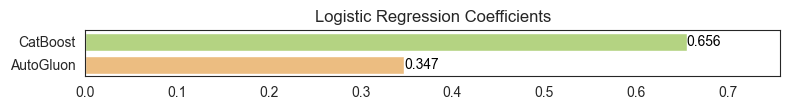

In [74]:
sorted_indices = np.argsort(coeffs[0])[::-1]
sorted_coeffs = np.array(coeffs[0])[sorted_indices]
sorted_model_names = np.array(list(oof_pred_probs.keys()))[sorted_indices]

plt.figure(figsize=(8, coeffs.shape[1] * 0.6))
ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")

for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
    if value > 0:
        ax.text(value, i, f'{value:.3f}', va='center', ha='left', color='black')
    else:
        ax.text(value, i, f'{value:.3f}', va='center', ha='right', color='black')

xlim = ax.get_xlim()
ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))
        
plt.title('Logistic Regression Coefficients')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [53]:
train = pd.read_csv("train.csv", index_col='id')
test = pd.read_csv("test.csv", index_col='id')

   /\  
  /__\  hillclimbers 
 /    \
/______\ 

Models to be ensembled | (2 total): 

CatBoost:  0.96840 (best solo model)
AutoGluon: 0.96451

[Data preparation completed successfully] - [Initiate hill climbing] 

Iteration: 1 | Model added: AutoGluon | Best weight: 0.454 | Best roc_auc_score: 0.96929


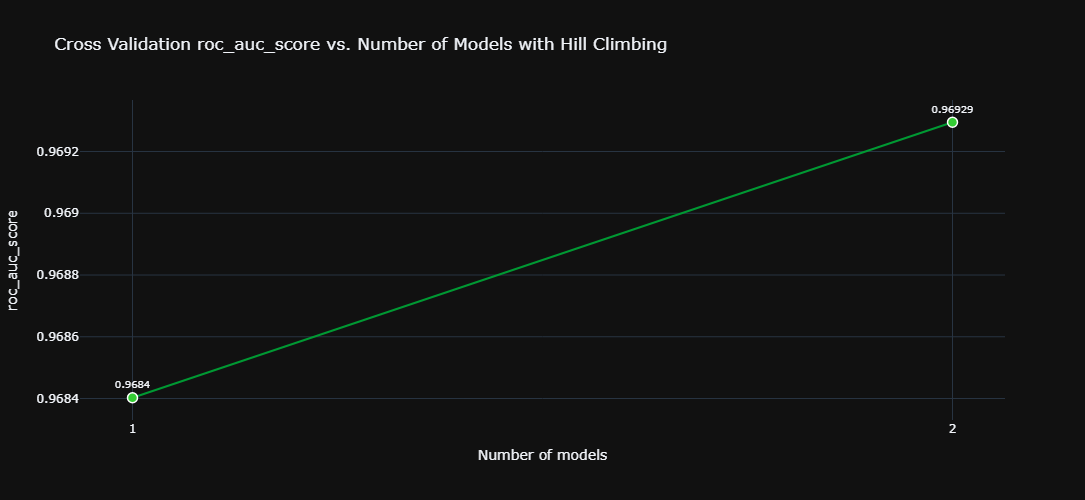

In [75]:
hc_test_pred_probs, hc_oof_pred_probs = climb_hill(
    train=train, 
    oof_pred_df=pd.DataFrame(oof_pred_probs), 
    test_pred_df=pd.DataFrame(test_pred_probs),
    target='loan_status',
    objective='maximize', 
    eval_metric=partial(roc_auc_score),
    negative_weights=True, 
    precision=0.001, 
    plot_hill=True, 
    plot_hist=False,
    return_oof_preds=True
)

In [79]:
hc_score = roc_auc_score(y, hc_oof_pred_probs)
scores['Hill Climbing'] = [hc_score] *5

In [80]:
hc_sub = pd.read_csv("sample_submission.csv")
hc_sub["loan_status"] = hc_test_pred_probs
hc_sub.to_csv(f'sub_hill-climbing_{hc_score:.6f}.csv', index=False)
hc_sub.head()

,id,loan_status
0,58645,0.993850
1,58646,0.044019
2,58647,0.590983
3,58648,0.011415
4,58649,0.064028


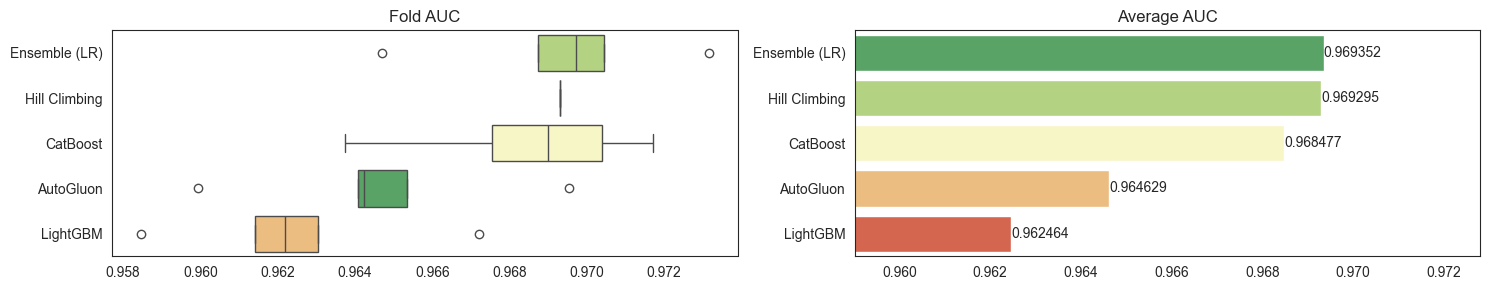

In [81]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.6))

sns.boxplot(data=scores, order=order, ax=axs[0], orient='h', palette='RdYlGn_r')
axs[0].set_title('Fold AUC')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], palette='RdYlGn_r')
axs[1].set_title('Average AUC')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_scores.values):
    barplot.text(score, i, round(score, 6), va='center')

plt.tight_layout()
plt.show()